In [1]:
# the Datacenter Computing team (@alexghergh)

In [1]:
from datasets import load_dataset
import torch
import torchvision
import pandas as pd
import matplotlib.pyplot as plt

torch.set_printoptions(precision=5, sci_mode=False)

# Don't worry about not understanding particular/specific things, the most important thing is to get the gist of it, and how the flow works! We'll have plenty of time to practice writing neural networks!

# We encourage you to search the Internet for explanations on any topics, as well as using chatbots to explain certain concepts, BUT please try the solutions for yourself first and make sure you understand (at least conceptually) what happens behind.

## 0. The dataset (MNIST digits)

### The MNIST digits problem consists in classifying a series of images into their corresponding digits classes.

It's a well-known problem, introduced in 1998 by Yann LeCun and his colleagues in a paper called "Gradient-Based Learning Applied to Document Recognition". It played a significant role in the early 2000s in revining the neural network interest. In contains 60.000 training images and 10.000 test images. More info about the dataset can be found at https://huggingface.co/datasets/ylecun/mnist.

We'll download the dataset from the huggingface hub (https://huggingface.co/datasets/ylecun/mnist). The huggingface hub contains a bunch of other datasets, for anything from text to image to audio, so it's a very good resource when looking for data to train your model.

In [2]:
mnist = load_dataset('ylecun/mnist')
mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

## 1. Visualization

Let's try to visualize this dataset and see what the data looks like.

![MNIST digits problem](./mnist_digits.png)

In [3]:
idx = 148
img = mnist['train'][idx]['image']
label = mnist['train'][idx]['label']
img

In [4]:
# helper function to transform a 28x28 pixel image into a tensor
def image_to_tensor(img):
    # first we'll use a transform from torchvision
    tr = torchvision.transforms.PILToTensor()
    img = tr(img)

    # we transform to float and divide by 255 (so we work with values between 0 and 1, not 0 and 255)
    img = img.float() / 255
    return img

In [5]:
# we now have a tensor of size (1, 28, 28), of float values between 0 and 1
img_t = image_to_tensor(img)
img_t.shape, img_t

(torch.Size([1, 28, 28]),
 tensor([[[0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,
           0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,
           0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,
           0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000],
          [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,
           0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,
           0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,
           0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000],
          [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,
           0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,
           0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,
           0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000],
          [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,
         

In [6]:
# let's visualize this tensor image more neatly
df = pd.DataFrame(img_t[0])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.188235,0.678431,0.996078,0.733333,0.101961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.419608,0.996078,0.925490,0.733333,0.870588,0.929412,0.149020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.254902,0.972549,0.945098,0.258824,0.000000,0.164706,0.992157,0.384314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015686,0.552941,0.956863,0.227451,0.000000,0.000000,0.082353,0.964706,0.980392,0.082353,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.270588,0.992157,0.466667,0.000000,0.000000,0.000000,0.000000,0.650980,0.992157,0.086275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 2. The neural network model and the training loop

We will use the PyTorch framework in order to build a neural network. The simplest neural network we can have is simply a stack between linear functions and non-linear (ReLU = Rectified Linear Unit) functions.

What we'll do in order to be able to pass an image through this network is to linearize the 28x28 tensor image, in a 784-entries array.

In [7]:
# see the docs: https://pytorch.org/docs/stable/generated/torch.reshape.html
img_t_resized = img_t.reshape(shape=(1,28*28))
img_t.shape, img_t_resized.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

Now let's create a model to pass this image through. Notice that our output (the dimension of linear layer) is 10, because we have 10 categories an image can be in (the digits 0-9).

In [8]:
model = torch.nn.Sequential(
    torch.nn.Linear(28*28, 10),
)
model

Sequential(
  (0): Linear(in_features=784, out_features=10, bias=True)
)

Let's print the total number of parameters, which, for a linear a*x+b, is equal to the numberof elements in the matrix a (size 784x10), plus the number of elements in the matrix b (size 1x10).

In [9]:
sum(p.numel() for p in model.parameters())

7850

Now we need a loss (error) function, to tell us how far off we are from the actual values. The way this will work is as follows:
1. Have the model output the 10 values, each value corresponding to each of the 10 digits.
2. Extract the value with the highest probability, and consider that as the model prediction (i.e. if the 4th value has the highest probability out of the 10, then we consider the model output to be "3", because we start at 0).
3. Compare this with the label of the image (e.g. an image with a label of "3" would ideally have a model output of [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]).

This sort of loss is called Cross-Entropy loss. We need this, as opposed to MSE (mean squared error), because we are working with categories now, not simply continuous values.

Read the PyTorch documentation to be sure what this does: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [10]:
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

We also need an "optimizer", i.e. a way to update (optimize) the parameters of the neural networks. This is the piece of code that automatically computes the new values for parameters, based on their gradients:
```python
a = a - lr * a_grad
```

For now, we'll use a very simple optimizer, the Stochastic Gradient Descent (SGD in short) optimizer. There are newer and better optimizers, but this is simple enough that we can use it and get something meaningful.

Make sure to read the docs to understand more about it: https://pytorch.org/docs/stable/generated/torch.optim.SGD.html.

We'll use a learning rate of 0.005. Too big or small of a learning rate will make the model diverge, or train very very slowly, respectively.

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Finally, we need something to serve us the data. In PyTorch, this is called a DataLoader. See the docs at https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader.

We'll use our MNIST dataset as the training dataset, with a batch size of 64 (i.e. we'll use 64 images through the model at one time). The loss function knows how to average those 64 images at one time. In practice, this makes the model more "stable" (converges to a solution faster/easier). There's a trade-off here, as with everything in engineering. Too big of a batch size, and the model might diverge, similar with a too small of a batch size. Usually values between 32 and 512 are safe to use with images.

The batch size and learning rate are the 2 most important hyperparameters one needs to set. You can try multiple combinations and see what works best.

In [12]:
# we need to transform our data a bit before passing to the DataLoader, because
# a DataLoader only accepts tensors, but we have images; we'll use the same transformation
# from above, but this time on the whole dataset
def preprocess_data(example):
    for i in range(len(example['image'])):
        # convert image to tensor
        example['image'][i] = image_to_tensor(example['image'][i])
        # reshape into an array/vector, instead of a matrix
        example['image'][i] = example['image'][i].reshape(shape=(1, 28*28))
    return example

# preprocess the dataset
mnist = mnist.with_transform(preprocess_data)

# create the dataloader (we'll also shuffle the images, as it helps the model see images in random order)
dl = torch.utils.data.DataLoader(mnist['train'], batch_size=64, shuffle=True)
dl

We finally have our training loop. This is the "heart" of neural network training, where the magic happens. We'll use our buildings blocks from above in order to train our model.

Remember the batch size and learning rate are the most important hyperparameters of a model. The third most important is arguably the number of epochs, which is the number of iterations through the whole dataset. 3 epochs means the model will see each image from the dataset 3 times, so it will have a chance to "learn" better about it. Usually, setting the epochs too high will cause the model to "overfit" on this dataset (i.e. it will generalize poorly to other, unseen images) so we don't want to set this too high. A number of epochs between 1 and 10 is generally fine.

In [13]:
epochs = 3
losses = []

for epoch in range(epochs):

    for batch in dl:
        # retrieve one batch of data from the dataloader
        inputs, targets = batch['image'].squeeze(dim=1), batch['label']

        # before anything else, make sure we have no gradients yet calculated/saved,
        # for any of the model parameters
        optimizer.zero_grad()

        # calculate the output of the model
        output = model(inputs)

        # calculate the loss (error) of the model with respect to the image labels (targets)
        loss = loss_fn(output, targets)

        # print and save this loss value
        print('loss: ', loss.item())
        losses.append(loss.item())

        # this is where the magic happens; PyTorch now calculates the gradients AUTOMATICALLY for us,
        # and the optimizer updates the parameters with these gradients
        loss.backward()
        optimizer.step()

loss:  2.358027219772339
loss:  2.348088502883911
loss:  2.313857078552246
loss:  2.287343740463257
loss:  2.327712297439575
loss:  2.281404972076416
loss:  2.296492576599121
loss:  2.2960920333862305
loss:  2.2570159435272217
loss:  2.2767181396484375
loss:  2.2999255657196045
loss:  2.2911107540130615
loss:  2.2863337993621826
loss:  2.2461414337158203
loss:  2.237787961959839
loss:  2.251513957977295
loss:  2.252425193786621
loss:  2.249817132949829
loss:  2.2403218746185303
loss:  2.2218704223632812
loss:  2.2092981338500977
loss:  2.217432975769043
loss:  2.1876332759857178
loss:  2.236436128616333
loss:  2.1774168014526367
loss:  2.205493927001953
loss:  2.202807903289795
loss:  2.2033252716064453
loss:  2.199788808822632
loss:  2.144768238067627
loss:  2.1658873558044434
loss:  2.1339876651763916
loss:  2.1697163581848145
loss:  2.164271831512451
loss:  2.144907236099243
loss:  2.131092071533203
loss:  2.1581459045410156
loss:  2.2104368209838867
loss:  2.133784770965576
loss:  

## 3. Visualizing the loss curve

And voila! Hopefully you notice the loss going down as the model sees more and more images, and "learns" to calibrate on the labels of the images.

We can visualize this loss history.

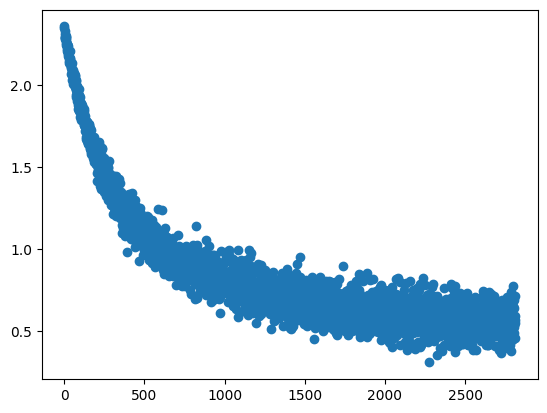

In [14]:
plt.scatter(range(len(losses)), losses)

This is our loss curve. Although it's a bit noisy, we can clearly see a trend downwards (minimizing the error/loss)!

For example, this is the loss graph of the LLama 1 language models, released by Meta in 2023 (paper: "LLaMA: Open and Efficient Foundation Language Models"). 

![Llama 1 loss curve](./llama1_loss.png)

## 4. Evaluating the model

Let's see how well the model behaves on the test set, i.e. the set of images that the model has NOT seen during training.

In [15]:
# set the model in evaluation mode; this tells PyTorch "do not calculate the gradients for me,
# as I do not need these now"
model.eval()

# let's also create a simple dataloader for the test set; although not necessary, it's easier
# to work with one (we'll evaluate one example at a time, and we don't need shuffling)
test_dl = torch.utils.data.DataLoader(mnist['test'], batch_size=1)

correct = 0
total = 0

with torch.no_grad():
    # iterate over the test set images
    for batch in test_dl:
        # get the input image and the label
        img, target = batch['image'].squeeze(dim=1), batch['label']

        # pass the image through the model
        output = model(img)

        # get the predicted class (the highest probability among the 10 classes of digits)
        predicted_class = torch.argmax(output, dim=1)

        # if correct, add 1
        total += 1
        correct += (predicted_class == target).sum().item()

accuracy = correct / total
print(f'accuracy: {accuracy * 100:.2f}%')

accuracy: 87.81%


Great, we obtained an accuracy of 87.85% (at least on my machine, might be slightly different on different runs).

## 5. Conclusions

Great, we trained from scratch a neural network to recognize images of digits, with a nice accuracy of 87%! Even though we trained this on CPU, it was still quite fast. If you have a GPU and willing to experiment, you can try to see just how much faster it goes!

You can try playing around with a lot of things in this notebook, and try to make it work better. For example, you can try a deeper/wider network architecture, or you can try with a different learning rate, batch size, number of epochs etc. Feel free to experiment, run, re-run and make sure you understand what each bit of the code does.

Here's just a simple example of a deeper and wider model, with ~12M parameters. Experiment and see what works best:

In [16]:
model = torch.nn.Sequential(
    torch.nn.Linear(28*28, 2 * 28*28),
    torch.nn.ReLU(),
    torch.nn.Linear(2 * 28*28, 4 * 28*28),
    torch.nn.ReLU(),
    torch.nn.Linear(4 * 28*28, 2 * 28*28),
    torch.nn.ReLU(),
    torch.nn.Linear(2 * 28*28, 28*28),
    torch.nn.ReLU(),
    torch.nn.Linear(28*28, 10),
)
model

Sequential(
  (0): Linear(in_features=784, out_features=1568, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1568, out_features=3136, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3136, out_features=1568, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1568, out_features=784, bias=True)
  (7): ReLU()
  (8): Linear(in_features=784, out_features=10, bias=True)
)

Finally, a note about modern state-of-the-art vision models. We've only worked with a simple neural network with nothing more but linearities and non-linearities in the form of ReLU functions. This is very primitive, and people don't usually do this for vision models nowadays. Instead, they use something called CNN's (convolutional neural networks). There's a bunch of intros to CNN's on the internet, so just look one up if you're interested. We'll skip these for now, and work with language models only for this course, using the Transformer architecture.